<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "IG-CA2"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/IG-CA2/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


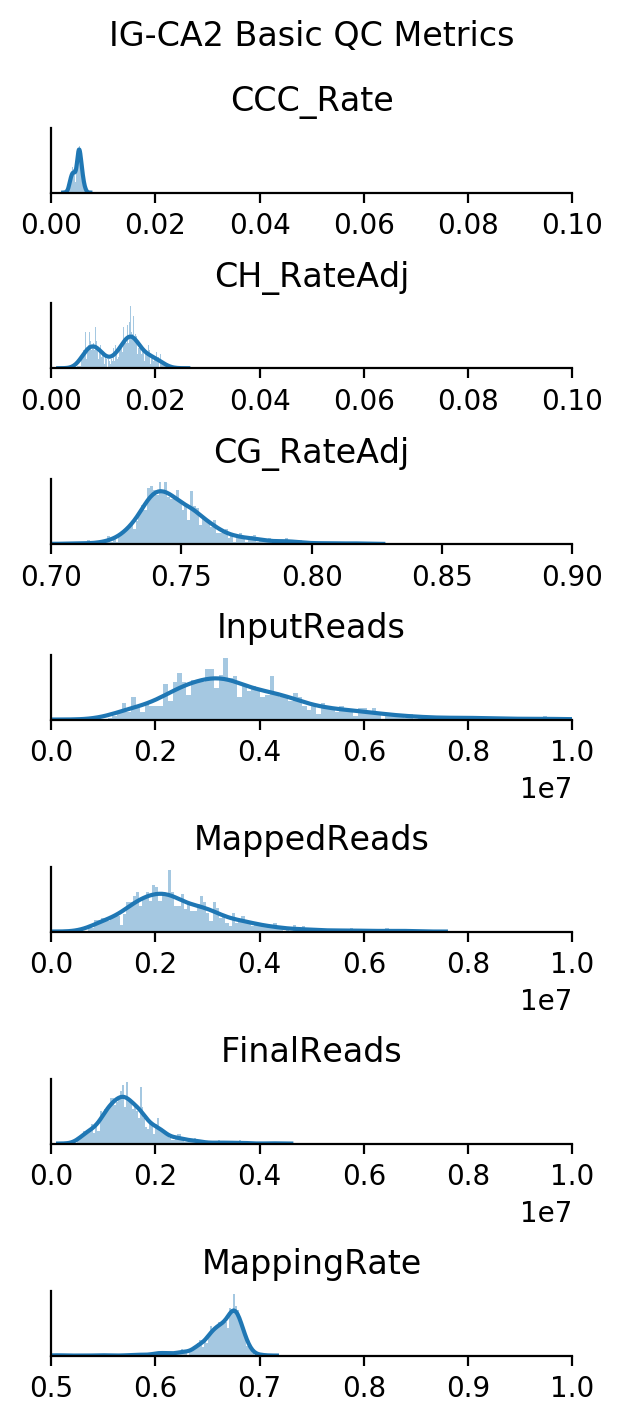

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

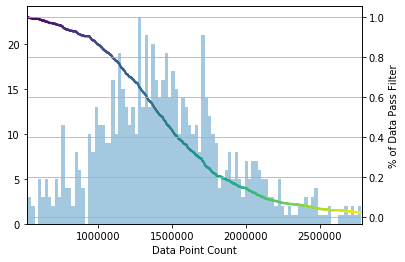

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 745/745 (100.0%)
CG_RateAdj passed 745/745 (100.0%)
CH_RateAdj passed 745/745 (100.0%)
FinalReads passed 745/745 (100.0%)
MappingRate passed 745/745 (100.0%)
Overall passed 745/745 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180129 1
180130 2
180205 10
180206 10
180917 48
181204 23
190108 13
190117 10
190205 16
190212 40
190214 4
190219 58
190305 1
190307 12
190625 12
190627 38
190711 214
190716 233


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 87 22.7%
ad002 104 27.1%
ad004 97 25.3%
ad006 92 24.0%
ad007 98 25.5%
ad008 99 25.8%
ad010 83 21.6%
ad012 85 22.1%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_1513,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.005502,0.744214,0.742799,0.020695,0.015277,1760210.0,4815796,3200112.0,10E,...,-36.042667,-7.550174,19.427386,15.619299,IG-CA2,-9.012033,-12.812195,37.974630,-22.781457,True
10E_M_1514,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006494,0.763033,0.761484,0.027601,0.021245,2054900.0,5719554,3757123.0,10E,...,-34.404137,-7.368342,22.882184,20.548928,IG-CA2,-7.805934,-9.765293,31.976396,-10.682003,True
10E_M_1702,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006173,0.751577,0.750033,0.026043,0.019993,1994939.0,5547086,3596406.0,10E,...,-34.248993,-7.657525,21.516055,16.900287,IG-CA2,-6.790865,-10.456732,29.011371,-13.151021,True
10E_M_1733,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.005819,0.751395,0.749940,0.024294,0.018583,2020446.0,6016876,3917352.0,10E,...,-34.531597,-7.547030,21.323028,16.763523,IG-CA2,-7.193950,-10.914946,29.760039,-14.358662,True
10E_M_1761,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006566,0.755320,0.753703,0.026416,0.019981,2409958.0,7266176,4844343.0,10E,...,-35.037998,-7.399627,20.802140,16.522049,IG-CA2,-7.416924,-11.092729,30.342417,-14.734722,True
10E_M_1780,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006126,0.757811,0.756318,0.026995,0.020998,2354449.0,6785428,4420204.0,10E,...,-34.174965,-7.681463,21.675435,16.953448,IG-CA2,-6.475302,-9.951886,28.287464,-12.032007,True
10E_M_1784,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006477,0.756622,0.755036,0.027652,0.021313,2283124.0,6575378,4360530.0,10E,...,-34.282749,-7.736801,21.541320,16.778778,IG-CA2,-6.714686,-10.557262,28.936865,-13.511467,True
10E_M_1786,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.005800,0.744420,0.742929,0.026105,0.020423,2000130.0,5882164,3814992.0,10E,...,-34.449501,-7.327575,22.766082,20.399503,IG-CA2,-7.548018,-10.491027,30.232566,-13.922989,True
10E_M_1788,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.006252,0.756617,0.755086,0.027685,0.021567,2763763.0,8166216,5369368.0,10E,...,-34.047676,-7.380266,22.663193,20.531421,IG-CA2,-7.558218,-9.573943,31.521719,-10.229972,True
